In [7]:
!git clone https://github.com/PratikSutar39/TrafficSigns
!ls TrafficSigns

Cloning into 'TrafficSigns'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), 47.34 MiB | 8.45 MiB/s, done.
signnames.csv  test.p  train.p	valid.p


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

In [9]:
np.random.seed(0)

In [10]:
# Load the dataset
with open('TrafficSigns/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('TrafficSigns/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('TrafficSigns/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [11]:
for i in range(13):
  print(i,': ',X_train[y_train==i].shape,X_val[y_val==i].shape,X_test[y_test==i].shape)

0 :  (180, 32, 32, 3) (30, 32, 32, 3) (60, 32, 32, 3)
1 :  (1980, 32, 32, 3) (240, 32, 32, 3) (720, 32, 32, 3)
2 :  (2010, 32, 32, 3) (240, 32, 32, 3) (750, 32, 32, 3)
3 :  (1650, 32, 32, 3) (210, 32, 32, 3) (630, 32, 32, 3)
4 :  (1260, 32, 32, 3) (150, 32, 32, 3) (450, 32, 32, 3)
5 :  (1920, 32, 32, 3) (240, 32, 32, 3) (720, 32, 32, 3)
6 :  (690, 32, 32, 3) (90, 32, 32, 3) (270, 32, 32, 3)
7 :  (1080, 32, 32, 3) (120, 32, 32, 3) (390, 32, 32, 3)
8 :  (540, 32, 32, 3) (60, 32, 32, 3) (180, 32, 32, 3)
9 :  (599, 32, 32, 3) (90, 32, 32, 3) (210, 32, 32, 3)
10 :  (360, 32, 32, 3) (60, 32, 32, 3) (120, 32, 32, 3)
11 :  (1080, 32, 32, 3) (120, 32, 32, 3) (390, 32, 32, 3)
12 :  (300, 32, 32, 3) (60, 32, 32, 3) (90, 32, 32, 3)


In [12]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(13649, 32, 32, 3)
(1710, 32, 32, 3)
(4980, 32, 32, 3)
(13649,)
(1710,)
(4980,)


In [13]:
assert(X_train.shape[0]==y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0]==y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

In [14]:
data = pd.read_csv('TrafficSigns/signnames.csv')
print(data)

    ClassId               SignName
0         0   Speed limit (20km/h)
1         1   Speed limit (30km/h)
2         2   Speed limit (50km/h)
3         3   Speed limit (80km/h)
4         4  Speed limit (120km/h)
5         5                  Yield
6         6                   Stop
7         7        General Caution
8         8        Traffic Signals
9         9       Turn Right Ahead
10       10        Turn left ahead
11       11             Ahead Only
12       12   Roundabout Mandatory


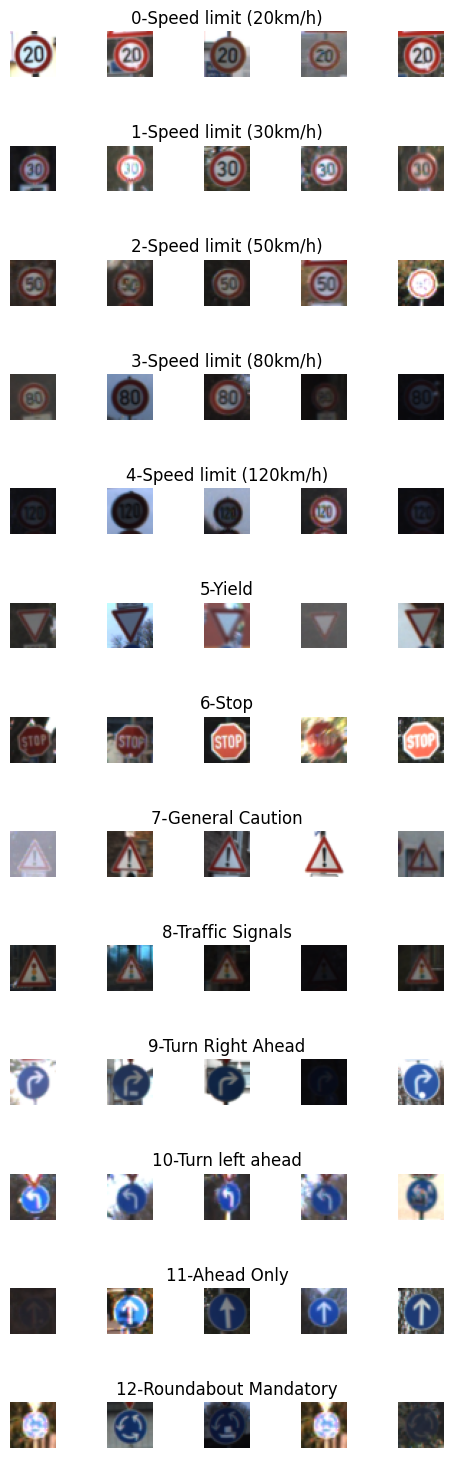

In [15]:
num_of_samples=[]

cols = 5
num_classes = 13

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,15))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))

In [16]:
print(len(num_of_samples))
print(num_of_samples)

13
[180, 1980, 2010, 1650, 1260, 1920, 690, 1080, 540, 599, 360, 1080, 300]


[180, 1980, 2010, 1650, 1260, 1920, 690, 1080, 540, 599, 360, 1080, 300]


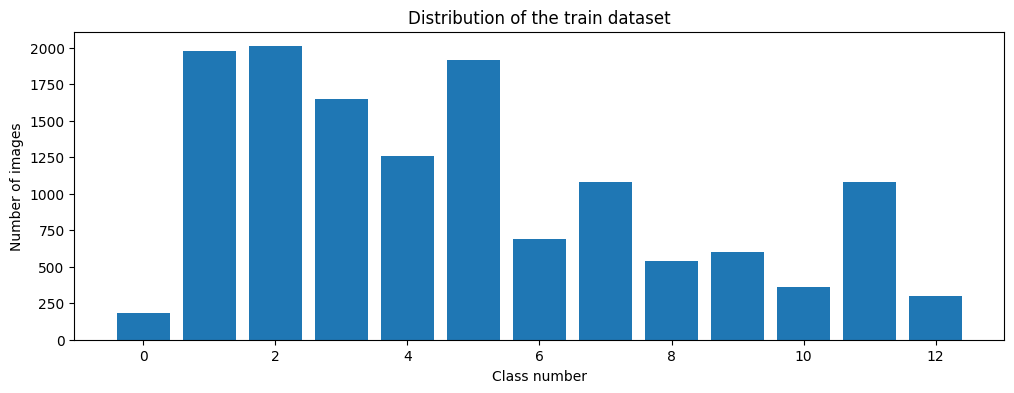

In [17]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, 13), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
1


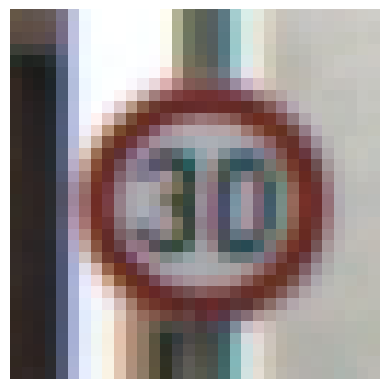

In [18]:
import cv2

plt.imshow(X_train[939])
plt.axis("off")
print(X_train[939].shape)
print(y_train[939])

(32, 32)


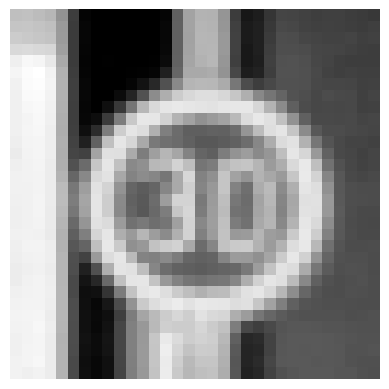

In [19]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

image = grayscale(X_train[939])
plt.imshow(image, cmap="binary")
plt.axis("off")
print(image.shape)

(32, 32)


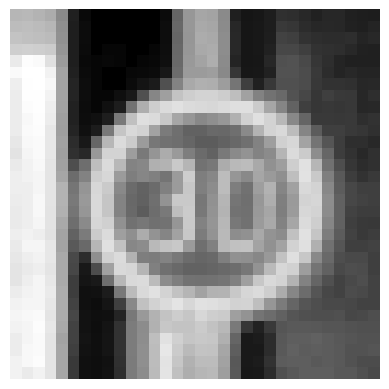

In [20]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

image2 = equalize(image)
plt.imshow(image2, cmap="binary")
plt.axis("off")
print(image2.shape)

In [21]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

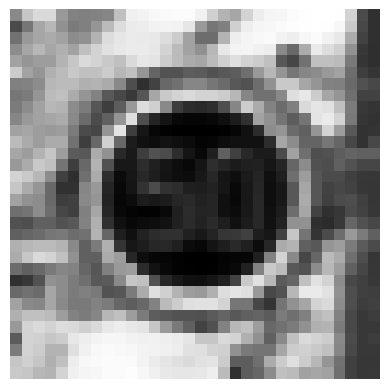

In [22]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap="binary")
plt.axis("off")
plt.show()

In [23]:
X_train = X_train.reshape(13649, 32, 32, 1)
X_test = X_test.reshape(4980, 32, 32, 1)
X_val = X_val.reshape(1710, 32, 32, 1)

In [24]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range= 0.2,
                             shear_range=0.1,
                             rotation_range=10)

datagen.fit(X_train)

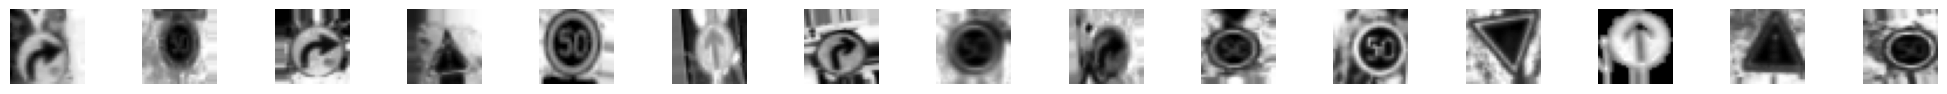

In [25]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32), cmap="binary")
  axs[i].axis('off')

In [26]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(13649, 32, 32, 1)
(4980, 32, 32, 1)
(1710, 32, 32, 1)


In [27]:
y_train = to_categorical(y_train, 13)
y_test = to_categorical(y_test, 13)
y_val = to_categorical(y_val, 13)

In [28]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [30]:
model = modified_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [31]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch=X_train.shape[0] / 50,
                    epochs=15,
                    validation_data=(X_val, y_val),
                    shuffle=1, callbacks=[early_stop])

Epoch 1/15
272/272 [==============================] - 17s 24ms/step - loss: 1.4187 - accuracy: 0.4877 - val_loss: 0.3827 - val_accuracy: 0.8924
Epoch 2/15
272/272 [==============================] - 6s 24ms/step - loss: 0.5582 - accuracy: 0.8046 - val_loss: 0.1570 - val_accuracy: 0.9456
Epoch 3/15
272/272 [==============================] - 6s 21ms/step - loss: 0.3092 - accuracy: 0.8981 - val_loss: 0.0562 - val_accuracy: 0.9825
Epoch 4/15
272/272 [==============================] - 6s 24ms/step - loss: 0.2048 - accuracy: 0.9310 - val_loss: 0.0937 - val_accuracy: 0.9743
Epoch 5/15
272/272 [==============================] - 6s 22ms/step - loss: 0.1536 - accuracy: 0.9510 - val_loss: 0.0202 - val_accuracy: 0.9953
Epoch 6/15
272/272 [==============================] - 7s 25ms/step - loss: 0.1112 - accuracy: 0.9648 - val_loss: 0.0300 - val_accuracy: 0.9924
Epoch 7/15
272/272 [==============================] - 6s 21ms/step - loss: 0.1097 - accuracy: 0.9651 - val_loss: 0.0260 - val_accuracy: 0.991

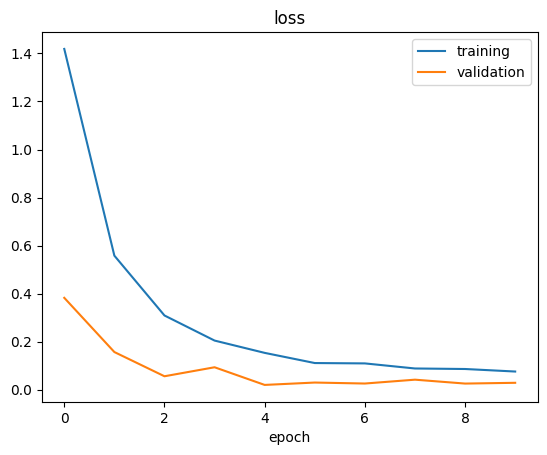

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()

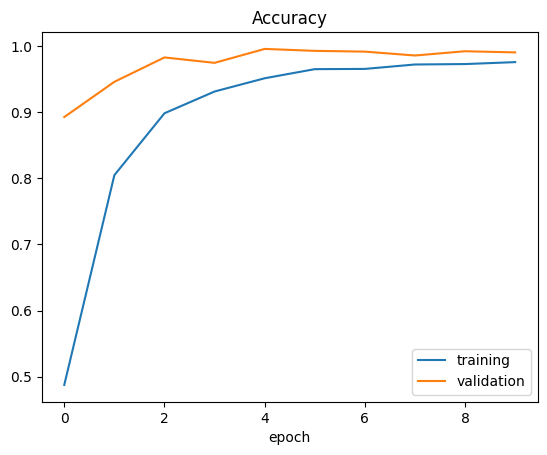

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [34]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.09153177589178085
Test Accuracy: 0.975301206111908


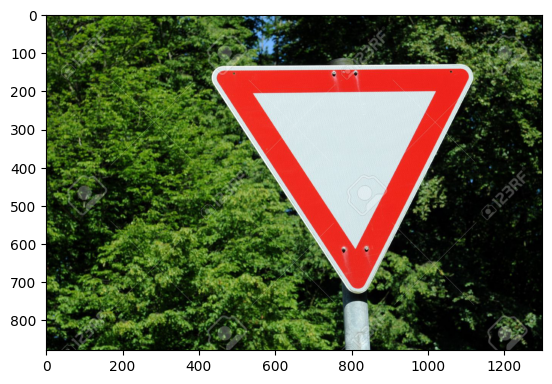

In [35]:
#fetch image

import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


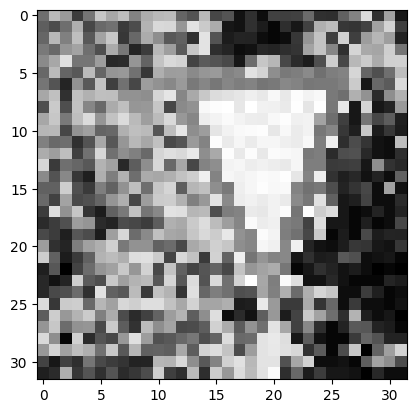

In [36]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [37]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [38]:
classes_ = {
0:   'Speed limit (20km/h)',
1:   'Speed limit (30km/h)',
2:   'Speed limit (50km/h)',
3:   'Speed limit (80km/h)',
4:  'Speed limit (120km/h)',
5:                  'Yield',
6:                   'Stop',
7:        'General Caution',
8:        'Traffic Signals',
9:       'Turn Right Ahead',
10:        'Turn left ahead',
11:             'Ahead Only',
12:   'Roundabout Mandatory',
}

In [39]:
#Test image

#print("predicted sign: "+ str(model.predict_classes(img)))

prediction = np.argmax(model.predict(img), axis=1)
predicted_class_name = classes_[prediction[0]]
print("Predicted sign :", predicted_class_name)
print("Predicted class :", prediction)

1/1 [==============================] - 0s 220ms/step
Predicted sign : Yield
Predicted class : [5]
